In [1]:
import numpy as np
import pickle
from tqdm import tqdm
import re
import collections
import glob
from transformers import DistilBertTokenizer, DistilBertModel
import sys
import time
import requests
from IPython.display import display, HTML
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup

sys.path.insert(0, '../src/models/')
sys.path.insert(0, '../src/features/')

from predict_model import loadBERT
from predict_model import SpanPredictor as classify
from build_features import text_cleaner, DuckDuckGo_Java, Bing_HTML, colorize_prediction

%matplotlib inline

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Load models

In [2]:
model = loadBERT("../models/", 'saved_weights_inf_FIXED_boot_beta80.pt')
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

CPU Success


## Load the species list

In [3]:
# Load POWO
#plants_list = pickle.load(open('../data/external/species_plants.pkl', 'rb'))
plants_dict = pickle.load(open('../data/processed/descriptions_powo_PLANTS.pkl', 'rb'))
#plants_list =[key for key in plants_dict.keys()]

In [4]:
# Order the dictionary based on the list length
plants_dict = collections.OrderedDict(sorted(plants_dict.items(), key= lambda x: len(x[1]), reverse=True))

In [5]:
plants = [key for key in plants_dict.keys()]

## Iterate Species

In [23]:
# Init dict
data = collections.defaultdict(list)
#data.update(plants_dict)
# DEBUGGING
data_links = collections.defaultdict(list)
# Init driver
driver = webdriver.Safari()


queries = ['description', 'diagnosis', '', 'attributes', 'captions']

for species in tqdm(plants[100:900]):
    # Empty list
    search_links = []
    
    for query in queries:
        # create query
        species_q = species.replace(' ', '+')
        species_q = f'"{species_q}"+{query}'
        try:
            search_links += DuckDuckGo_Java(species_q, 
                                            driver=driver)
            search_links += Bing_HTML(species_q)
         # Skip connection timeout
        except:
            continue
    # Drop duplicates
    search_links = list(set(search_links))
    # DEBUGGING
    data_links[species] += search_links
    # Loop over the URLs
    for URL in search_links:
        # Skip google archives
        if 'google' in URL:
            continue
        # PDF and TXT
        if URL.endswith('txt') or URL.endswith('pdf'):
            continue
        try:
            page = requests.get(URL, timeout=5)
            # Skip PDF files for now
            if page.headers['Content-Type'].startswith('application/pdf'):
                continue
            # Soup the result
            soup = BeautifulSoup(page.content, 'html.parser')    
            # Skip Embedded PDF's
            if 'pdf' in soup.title.text.lower():
                continue
            # Check if species exists somewhere within title
            if bool(set(species.split()).intersection(soup.title.text.split())):
                # Get text
                #dirty_text = soup.get_text(". ", strip=True)
                dirty_text = soup.get_text(" ", strip=False).replace('\n', '.')
                # Clean and break into sents
                sentences = text_cleaner(dirty_text)
                # Loop over the individual sentences
                for sentence in sentences:                    
                    # Create string object
                    sentence_str = str(sentence)
                    # Check if description
                    if classify(sentence_str, model=model):
                        if sentence_str not in data[species]:
                            data[species].append((sentence_str, URL))                            
        except: 
            continue
            
driver.quit()

 22%|███████▊                            | 174/800 [5:57:52<13:18:01, 76.49s/it]Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
 28%|█████████▋                         | 221/800 [7:24:38<21:30:18, 133.71s/it]Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
 29%|██████████▏                        | 233/800 [7:51:18<18:50:02, 119.58s/it]Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
 31%

In [24]:
# Dump pickle into file
with open('../data/description/descriptions_100-900.pkl', 'wb') as f:
    pickle.dump(data, f)

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

In [26]:
# Change this to the dissimilar in future
counts = [len(sents) for key, sents in data.items()]

In [27]:
len(counts)

757

Text(0.5, 1.0, 'Histogram')

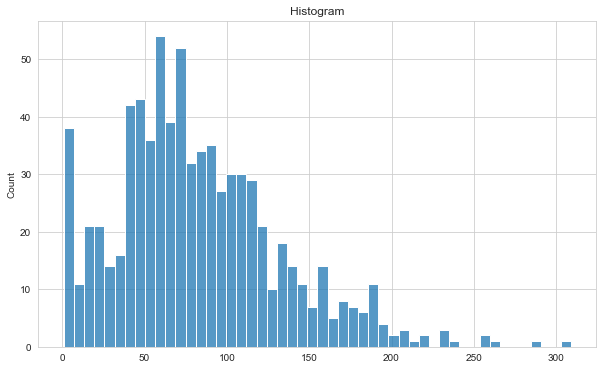

In [29]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.set_style('whitegrid')
ax = sns.histplot(counts, bins=50)
ax.set_title('Histogram')
#plt.xlim(0, 300)

In [ ]:
html = colorize_prediction(
    ['Something about a bird or plant',
     'The bill and the legs are both black.',
     'The house is large with enormous windows.',
     'This is something random, but the sexes are similar.',
     'Nuclear power might solve the energy power.',
     'The tree has a brown bark and the leaves are pointed',
     'By growing in shaded places, the plant reduces evaporation.',
     '3 cm seeds.'],
model=model)

In [ ]:
display(HTML(html))

In [ ]:
Html_file= open("test","w")
Html_file.write(xxx)
Html_file.close()

In [ ]:
xxx= html.replace('\n', '')

In [ ]:
URL = "https://www.beautyofbirds.com/europeanrobins.html"
page = requests.get(URL, timeout=5)
soup = BeautifulSoup(page.content, 'html.parser')  
dirty_text = soup.get_text(" ", strip=False).replace('\n', '.')
sents = text_cleaner(dirty_text)

In [ ]:
html = colorize_prediction(sents[0:5], model=model)

In [10]:
dirty_text = """
The red cotton tree (Bombax ceiba) is a medium- to large-sized tropical tree that usually grows to an average of 20-25 meters, with old trees up to 60 meters in wet tropical weather. It has a straight tall trunk buttressed at base that bears conical spines to deter animal attacks. Its leaves are deciduous in winter. Crimson red flowers with five petals appear in the spring before the new foliage and are one reason that the tree is widely planted. It produces a capsule which, when ripe, contains white fibres, like cotton, which has been used as a substitute for cotton (hence its common name). 
"""

In [14]:
sents = text_cleaner(dirty_text)
html = colorize_prediction(sents, model=model, tex=True)
display(HTML(html))

Copy paste this in the .tex file
\definecolor{color1}{HTML}{00441b}
\definecolor{color2}{HTML}{aadfd3}
\definecolor{color3}{HTML}{f7fcfd}
\definecolor{color4}{HTML}{d5efed}
\definecolor{color5}{HTML}{1f8742}
\sethlcolor{color1}\hl{The red cotton tree is a medium- to large-sized tropical tree that usually grows to an average of 20-25 meters, with old trees up to 60 meters in wet tropical weather. < 0.870 >}
\sethlcolor{color2}\hl{Its leaves are deciduous in winter. < 0.396 >}
\sethlcolor{color3}\hl{It produces a capsule which, when ripe, contains white fibres, like cotton, which has been used as a substitute for cotton. < 0.158 >}
\sethlcolor{color4}\hl{Crimson red flowers with five petals appear in the spring before the new foliage and are one reason that the tree is widely planted. < 0.303 >}
\sethlcolor{color5}\hl{It has a straight tall trunk buttressed at base that bears conical spines to deter animal attacks. < 0.701 >}


In [12]:
html = html.replace('\n', '')

In [13]:
Html_file = open("web_crawler_example","w")
Html_file.write(html)
Html_file.close()

In [13]:
test = """
Large-billed Flycatcher is most similar to Hill Blue Flycatcher in plumage coloration, but has paler orange throat more contrasting with breast (16). Structural differences include the larger, strongly hook-tipped and broader bill, slightly larger size (11), longer primary projection (10), paler legs, and proportionally shorter tail and legs than Hill Blue Flycatcher (9, 17). Juvenile Large Blue Flycatcher is said to have more colorful upperparts (18). Males of most Chinese Blue Flycatchers and some Blue-throated Flycatcher have distinctly narrower orange-rufous wedge extending up to the dark blue throat and blue across upper throat below jaw-level (7), but the orange notch on throat is often wide and extending up to chin (17).

Male Tickell’s Blue Flycatcher (C. tickelliae) and Indochinese Blue Flycatcher (C. tickelliae) are slightly paler overall, with blue of upperparts not as deep (11) and much less contrasting bright frontal band and carpus edge. Females of both species differ in having bluish-tinged upperparts, albeit often barely perceivable in northern subspecies of Indochinese Blue Flycatcher (C. t. indochina), and markedly blue rump and uppertail, not strongly rufescent as in Hill Blue Flycatcher (19). Note that female Hill Blue Flycatcher occasionally possesses bluish upperparts and rump (19, 7), but it still features more intense rufous orange throat and breast. Indochinese Blue Flycatcher is diagnostic in having a consistently sharp demarcation between orange upper breast and clean white rest of underparts, without any orange on flanks (20, 21, 19).
"""

In [14]:
text_cleaner(test)

['Juvenile Large Blue Flycatcher is said to have more colorful upperparts.',
 'Structural differences include the larger, strongly hook-tipped and broader bill, slightly larger size , longer primary projection , paler legs, and proportionally shorter tail and legs than Hill Blue Flycatcher.',
 'Females of both species differ in having bluish-tinged upperparts, albeit often barely perceivable in northern subspecies of Indochinese Blue Flycatcher , and markedly blue rump and uppertail, not strongly rufescent as in Hill Blue Flycatcher.',
 'Tickell’s Blue Flycatcher and Indochinese Blue Flycatcher are slightly paler overall, with blue of upperparts not as deep and much less contrasting bright frontal band and carpus edge.',
 'Indochinese Blue Flycatcher is diagnostic in having a consistently sharp demarcation between orange upper breast and clean white rest of underparts, without any orange on flanks.',
 'Large-billed Flycatcher is most similar to Hill Blue Flycatcher in plumage coloratio